In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import terra
import seaborn as sns
import meerkat as mk
import numpy as np
from meerkat.contrib.gqa import read_gqa_dps
from domino.data.visual_genome import ATTRIBUTE_GROUPS

In [3]:
dps = read_gqa_dps("/home/common/datasets/gqa")
object_dp, image_dp, attr_dp = dps["objects"], dps["images"], dps["attributes"]

In [4]:
from domino.slices.gqa import collect_correlation_slices
from domino.slices.train import train_slices

slices_dp = collect_correlation_slices.out(4690, load=True)

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [32]:
object_dp["name"].data.value_counts().iloc[10:50]

head        18762
pole        16968
hand        16626
grass       16194
hair        15905
leg         15487
car         13074
woman       12958
trees       12154
table       12154
leaves      12144
ear         12075
pants       10794
people      10676
eye         10622
water       10046
door         9995
fence        9112
nose         8739
wheel        8721
chair        8455
floor        8372
arm          8245
jacket       8147
hat          8030
shoe         8000
tail         7453
clouds       7316
leaf         7280
face         7211
letter       7085
plate        7006
number       7003
windows      6714
shorts       6438
road         6375
flower       6133
sidewalk     6112
bag          5874
helmet       5584
Name: name, dtype: int64

In [46]:
object_dp.lz[object_dp["name"].isin([
    "shirt",
    "t-shirt",
    "skirt",
    "scarf",
    "tie",
    "pants",
    "boot",
    "boots",
    "shorts",
    "jacket",
    "coat",
    "sweater",
    "sweatshirt",
    "dress",
    "hat",
    "shoe",
    "shoes",
    "glove",
    "gloves",
    "suit",
])]['name'].data.value_counts()

shirt         28722
pants         10794
jacket         8147
hat            8030
shoe           8000
shorts         6438
shoes          4305
coat           3378
glove          2952
tie            2174
dress          1707
t-shirt        1580
sweater        1504
suit           1296
boot           1283
gloves         1155
skirt          1102
boots          1051
scarf           946
sweatshirt      348
Name: name, dtype: int64

In [29]:
object_dp["name"].isin(["turkey"]).sum()

41

In [7]:
y = dp["name"].isin(["dog", "cow", "cat", "bird", "horse"])
y_hat = np.zeros(len(y))

PARAM_A = 1
PARAM_B = 7
mask = dp["name"].isin(["cat", "horse"])
y_hat[mask] = np.random.beta(PARAM_A, PARAM_B, mask.sum())

mask = dp["name"].isin(["dog", "cow", "bird"])
y_hat[mask] = np.random.beta(PARAM_B, PARAM_A, mask.sum())

mask = dp["name"].isin(["pizza", "tree"])
y_hat[mask] = np.random.beta(PARAM_A, PARAM_B, mask.sum())

y_oh = np.zeros((len(y), 2))
y_oh[y == 0, 0] = 1
y_oh[y == 1, 1] = 1
y = y_oh
y_hat = np.array([1 - y_hat, y_hat]).T

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 8, max_iter = 1000, tol = 1e-4)
out = gmm.fit_predict(X)

In [9]:
dp["clusters"] = out
df = dp[["name", "clusters"]].to_pandas()
df.groupby("clusters")["name"].value_counts()

clusters  name 
0         tree     8280
          cat         4
          pizza       4
          bird        3
          cow         3
          dog         3
          horse       3
1         tree     4777
          horse    2101
          cow       223
          bird      211
          dog       123
          cat        51
          pizza      26
2         tree     2324
          cow      2104
          bird     1952
          horse    1113
          dog        99
          cat        11
          pizza       2
3         pizza    1986
          dog        40
          bird        8
          tree        8
          cat         6
          horse       3
          cow         2
4         tree     4541
          bird        9
          horse       5
          cow         3
          cat         2
          pizza       2
5         dog      2590
          cat      2195
          tree       77
          cow        30
          bird       14
          pizza      11
          horse       7


,object_image (LambdaColumn),name (PandasSeriesColumn)
0,,cat
1,,cat
2,,dog
3,,cat
4,,cat
...,...,...
4992,,dog
4993,,cat
4994,,cat
4995,,dog

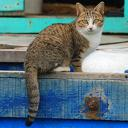
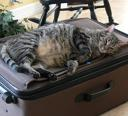
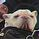
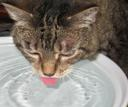
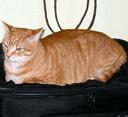
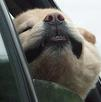
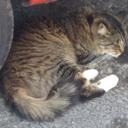
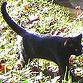
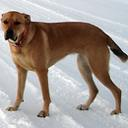
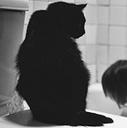

In [103]:
dp[["object_image", "name"]].lz[dp["clusters"] == 6]

In [31]:
from domino.sdm.gmm import ErrorGMM
gmm = ErrorGMM(
    weight_y_log_likelihood=25, 
    n_components = 8, 
    max_iter = 100, 
    tol = 1e-4, 
    covariance_type="diag"
)
out = gmm.fit_predict(X, y, y_hat)

 23%|██▎       | 23/100 [00:04<00:15,  4.85it/s]


In [32]:
dp["clusters"] = out
df = dp[["name", "clusters"]].to_pandas()
df.groupby("clusters")["name"].value_counts()

clusters  name 
0         cat       2130
          dog          1
          horse        1
1         tree      6350
          pizza      162
2         bird      3899
          dog       3057
          cow       2842
          horse       17
          cat          7
3         tree     11549
          pizza       79
4         tree      4345
          pizza       43
5         horse     3444
          cat        186
          dog          4
          bird         2
          cow          1
6         pizza     1807
          tree         2
7         tree      4746
          pizza        4
Name: name, dtype: int64

In [150]:
mask = dp["clusters"] == 6
(gmm._estimate_y_log_prob(y[mask], y_hat[mask])[:, 6]).mean()

-0.7484833457498595

In [22]:
np.finfo(gmm.y_hat_probs.dtype).eps

2.220446049250313e-16

In [20]:
gmm.resp

AttributeError: 'ErrorGMM' object has no attribute 'resp'